In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from dirty_cat import SuperVectorizer
from dirty_cat.datasets import fetch_employee_salaries
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 


/kaggle/input/nfl-big-data-bowl-2025/players.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_7.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_9.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_6.csv
/kaggle/input/nfl-big-data-bowl-2025/games.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_8.csv
/kaggle/input/nfl-big-data-bowl-2025/player_play.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_4.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_3.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_1.csv
/kaggle/input/nfl-big-data-bowl-2025/plays.csv
/kaggle/input/nfl-big-data-bowl-2025/tracking_week_2.csv


In [36]:
!pip install dirty_cat -q

In [3]:
games = pd.read_csv('../input/nfl-big-data-bowl-2025/games.csv')
plays = pd.read_csv('../input/nfl-big-data-bowl-2025/plays.csv')
players = pd.read_csv('../input/nfl-big-data-bowl-2025/players.csv')
players_play = pd.read_csv('../input/nfl-big-data-bowl-2025/player_play.csv')
players_play.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
p_g = pd.merge(plays, games, on='gameId', how='inner') 
p_p = pd.merge(players, players_play, on='nflId', how='inner')

In [37]:
from skrub import TableReport

TableReport(p_g)

ImportError: cannot import name '_TrimmedRelease' from 'packaging.version' (/opt/conda/lib/python3.10/site-packages/packaging/version.py)

In [30]:
null_percentage = p_g.isnull().sum() / len(df) * 100
columns_less_than_10_percent_null = null_percentage[null_percentage < 10].index
pg_f = p_g.filter(columns_less_than_10_percent_null, axis=1)
pg_f['game_clock_seconds'] = pg_f['gameClock'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
pg_f.dropna()
print(pg_f.columns)

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [38]:
y = pg_f['pff_runPassOption']
X = pg_f.filter(['quarter','game_clock_seconds','playClockAtSnap','absoluteYardlineNumber', 'down', 'yardsToGo','yardlineNumber','offenseFormation', 'receiverAlignment','pff_passCoverage','pff_manZone'])
def plot_feature_importance(pipeline, features):
    importances = pipeline[1].feature_importances_
    feature_importance_df = (
        pd.DataFrame({"feature": features, "importances": importances})
        .sort_values("importances")
        .tail(10)
    )
    fig = px.bar(
        feature_importance_df, x="importances", y="feature", title="Feature Importance"
    )
    fig.show()


def pipeline_model(encoder, X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(encoder, RandomForestRegressor(), verbose=True)
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    print(f"Train score: {train_score:.3f}, Test score: {test_score:.3f}")
    features = pipeline[0].get_feature_names_out()
    print(f"Num cols after encoding: {len(features)}")
    print(f"Encoded columns: ...{features[-5:]}")

    plot_feature_importance(pipeline, features)
    return pipeline, features

In [43]:
importances = pipeline[1].feature_importances_
feature_importance_df = (
        pd.DataFrame({"feature": features, "importances": importances})
        .sort_values("importances")
        .tail(10)
    )
print(feature_importance_df)

                      feature  importances
24   pff_passCoverage_Cover-1     0.017676
36  pff_passCoverage_Quarters     0.021623
27   pff_passCoverage_Cover-3     0.027534
12      receiverAlignment_2x2     0.035869
14      receiverAlignment_3x1     0.036500
4    offenseFormation_SHOTGUN     0.048106
44                       down     0.051119
43                    quarter     0.119663
45                  yardsToGo     0.125334
46             yardlineNumber     0.392619


<Axes: xlabel='importances', ylabel='feature'>

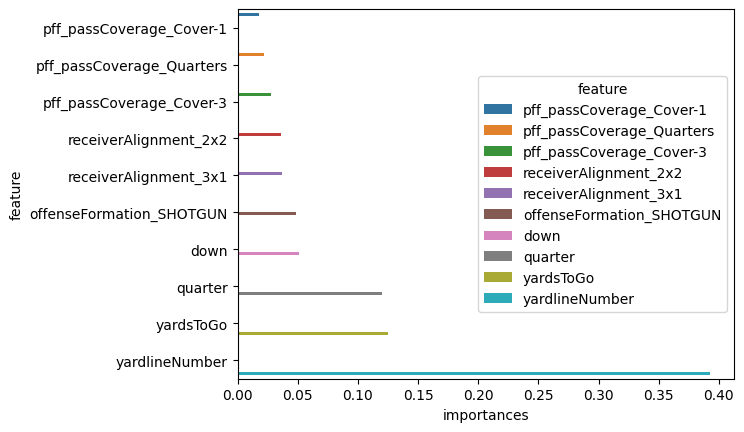

In [49]:
sns.barplot(feature_importance_df, x="importances", y="feature", hue="feature")

In [39]:
super_encoder = SuperVectorizer()
pipeline, features = pipeline_model(super_encoder, X_train, y_train, X_test, y_test)

[Pipeline] ... (step 1 of 2) Processing supervectorizer, total=   3.9s
[Pipeline]  (step 2 of 2) Processing randomforestregressor, total= 8.3min


/opt/conda/lib/python3.10/site-packages/dirty_cat/_table_vectorizer.py:518: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/opt/conda/lib/python3.10/site-packages/dirty_cat/_table_vectorizer.py:518: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

Train score: 0.775, Test score: 0.770
Num cols after encoding: 47
Encoded columns: ...['pff_manZone_nan', 'quarter', 'down', 'yardsToGo', 'yardlineNumber']


In [41]:
print(features)

['offenseFormation_EMPTY', 'offenseFormation_I_FORM', 'offenseFormation_JUMBO', 'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN', 'offenseFormation_SINGLEBACK', 'offenseFormation_WILDCAT', 'offenseFormation_nan', 'receiverAlignment_1x0', 'receiverAlignment_1x1', 'receiverAlignment_2x0', 'receiverAlignment_2x1', 'receiverAlignment_2x2', 'receiverAlignment_3x0', 'receiverAlignment_3x1', 'receiverAlignment_3x2', 'receiverAlignment_3x3', 'receiverAlignment_4x1', 'receiverAlignment_4x2', 'receiverAlignment_nan', 'pff_passCoverage_2-Man', 'pff_passCoverage_Bracket', 'pff_passCoverage_Cover 6-Left', 'pff_passCoverage_Cover-0', 'pff_passCoverage_Cover-1', 'pff_passCoverage_Cover-1 Double', 'pff_passCoverage_Cover-2', 'pff_passCoverage_Cover-3', 'pff_passCoverage_Cover-3 Cloud Left', 'pff_passCoverage_Cover-3 Cloud Right', 'pff_passCoverage_Cover-3 Double Cloud', 'pff_passCoverage_Cover-3 Seam', 'pff_passCoverage_Cover-6 Right', 'pff_passCoverage_Goal Line', 'pff_passCoverage_Miscellaneous